In [7]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [1]:
import zipline
zipline.__version__

'2.4'

In [8]:
%reload_ext zipline

In [24]:
%%zipline --start 2015-1-1 --end 2018-1-1 --output single_factor.pickle --no-benchmark --bundle quandl

from zipline.api import (attach_pipeline, date_rules, time_rules, order_target_percent, pipeline_output,
    record, schedule_function, get_open_orders, calendars)
from zipline.finance import commission, slippage
from zipline.pipeline import Pipeline, CustomFactor
from zipline.pipeline.factors import Returns, AverageDollarVolume
import numpy as np
import pandas as pd

MONTH = 21
YEAR = 12 * MONTH
N_LONGS = N_SHORTS = 25
VOL_SCREEN = 100


class MeanReversion(CustomFactor):
    # Returns : Calculates the % change in close price over the given window_length
    inputs = [Returns(window_length=MONTH)] # for 12 months
    window_length = YEAR

    def compute(self, today, assets, out, monthly_returns):
        df = pd.DataFrame(monthly_returns)
        out[:] = df.iloc[-1].sub(df.mean()).div(df.std()) # normalized by std dev of monthly returns


def compute_factors():
    # create factor pipeline with mean reversion
    mean_reversion = MeanReversion()
    # filter: factor rank by 30d dollar volume  
    dollar_volume = AverageDollarVolume(window_length=30) 
    return Pipeline(columns={'longs': mean_reversion.bottom(N_LONGS), 'shorts': mean_reversion.top(N_SHORTS),
                             'ranking': mean_reversion.rank(ascending=False)},
                    screen=dollar_volume.top(VOL_SCREEN))


def exec_trades(data, assets, target_percent):
    # Place orders for assets using target portfolio percentage
    for asset in assets:
        # get_open_orders : Retrieve all of the current open orders        
        if data.can_trade(asset) and not get_open_orders(asset):
            order_target_percent(asset, target_percent)


def rebalance(context, data):
    # Compute long, short and obsolete holdings
    factor_data = context.factor_data
    record(factor_data=factor_data.ranking)

    assets = factor_data.index
    record(prices=data.current(assets, 'price'))

    longs = assets[factor_data.longs]
    shorts = assets[factor_data.shorts]
    divest = set(context.portfolio.positions.keys()) - set(longs.union(shorts))

    # place trade orders
    exec_trades(data, assets=divest, target_percent=0)
    exec_trades(data, assets=longs, target_percent=1 / N_LONGS)
    exec_trades(data, assets=shorts, target_percent=-1 / N_SHORTS)


def initialize(context):
    # attach_pipeline: register pipeline, schedule rebalancing, and set trading params
    attach_pipeline(compute_factors(), 'factor_pipeline')
    # schedule_function(func, date_rule=None, time_rule=None, half_days=True, calendar=None)
    # date_rules.week_start() : Create a rule that triggers a fixed number of trading days after the start of each week
    # time_rules.market_open() : Create a rule that triggers a fixed offset from market open.
    schedule_function(rebalance, date_rules.week_start(), time_rules.market_open(),
                      calendar=calendars.US_EQUITIES)
    context.set_commission(commission.PerShare(cost=.01, min_trade_cost=0))
    context.set_slippage(slippage.VolumeShareSlippage())


def before_trading_start(context, data):
    # Run factor pipeline daily basis
    context.factor_data = pipeline_output('factor_pipeline')

,period_open,period_close,pnl,positions,starting_exposure,longs_count,ending_exposure,orders,starting_cash,returns,...,algo_volatility,period_label,max_drawdown,benchmark_period_return,benchmark_volatility,excess_return,sortino,max_leverage,factor_data,prices
2015-01-02 21:00:00+00:00,2015-01-02 14:31:00+00:00,2015-01-02 21:00:00+00:00,0.000000,[],0.00,0,0.00,[],1.000000e+07,0.000000,...,NaN,2015-01,0.000000,0.0,NaN,0.0,NaN,0.000000,NaN,NaN
2015-01-05 21:00:00+00:00,2015-01-05 14:31:00+00:00,2015-01-05 21:00:00+00:00,0.000000,[],0.00,0,0.00,"[{'id': 'e041bf8878854db1995aff9a7577c757', 'd...",1.000000e+07,0.000000,...,0.000000,2015-01,0.000000,0.0,0.0,0.0,NaN,0.000000,Equity(2 [AAL]) 870.0 Equity(8 [AAPL])...,Equity(2 [AAL]) 53.875 Equity(8 [AAPL]...
2015-01-06 21:00:00+00:00,2015-01-06 14:31:00+00:00,2015-01-06 21:00:00+00:00,-42.688831,"[{'sid': Equity(2195 [PEP]), 'amount': 4267, '...",0.00,1,396916.34,"[{'id': 'e041bf8878854db1995aff9a7577c757', 'd...",1.000000e+07,-0.000004,...,0.000039,2015-01,-0.000004,0.0,0.0,0.0,-9.165151,0.039692,Equity(2 [AAL]) 870.0 Equity(8 [AAPL])...,Equity(2 [AAL]) 53.875 Equity(8 [AAPL]...
2015-01-07 21:00:00+00:00,2015-01-07 14:31:00+00:00,2015-01-07 21:00:00+00:00,11606.240000,"[{'sid': Equity(2195 [PEP]), 'amount': 4267, '...",396916.34,1,408522.58,[],9.603041e+06,0.001161,...,0.009224,2015-01,-0.000004,0.0,0.0,0.0,2150.052699,0.040805,Equity(2 [AAL]) 870.0 Equity(8 [AAPL])...,Equity(2 [AAL]) 53.875 Equity(8 [AAPL]...
2015-01-08 21:00:00+00:00,2015-01-08 14:31:00+00:00,2015-01-08 21:00:00+00:00,7424.580000,"[{'sid': Equity(2195 [PEP]), 'amount': 4267, '...",408522.58,1,415947.16,[],9.603041e+06,0.000742,...,0.008610,2015-01,-0.000004,0.0,0.0,0.0,3156.372020,0.041516,Equity(2 [AAL]) 870.0 Equity(8 [AAPL])...,Equity(2 [AAL]) 53.875 Equity(8 [AAPL]...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-22 21:00:00+00:00,2017-12-22 14:31:00+00:00,2017-12-22 21:00:00+00:00,4267.650000,"[{'sid': Equity(1720 [LRCX]), 'amount': 2156, ...",795896.19,2,800163.84,[],9.376948e+06,0.000420,...,0.022630,2017-12,-0.056341,0.0,0.0,0.0,0.383575,0.528461,Equity(8 [AAPL]) 1826.0 Equity(12 [ABBV])...,Equity(8 [AAPL]) 176.42 Equity(12 [ABBV])...
2017-12-26 21:00:00+00:00,2017-12-26 14:31:00+00:00,2017-12-26 21:00:00+00:00,-2207.630000,"[{'sid': Equity(1720 [LRCX]), 'amount': 2156, ...",800163.84,2,797956.21,"[{'id': 'a03aabfdc1dc49179119666dd69b2cc1', 'd...",9.376948e+06,-0.000217,...,0.022615,2017-12,-0.056341,0.0,0.0,0.0,0.378769,0.528461,Equity(8 [AAPL]) 1862.0 Equity(12 [ABBV])...,Equity(8 [AAPL]) 170.57 Equity(12 [ABBV])...
2017-12-27 21:00:00+00:00,2017-12-27 14:31:00+00:00,2017-12-27 21:00:00+00:00,4613.778057,"[{'sid': Equity(1531 [ISRG]), 'amount': 1112, ...",797956.21,2,818372.80,"[{'id': 'a03aabfdc1dc49179119666dd69b2cc1', 'd...",9.376948e+06,0.000453,...,0.022602,2017-12,-0.056341,0.0,0.0,0.0,0.388000,0.528461,Equity(8 [AAPL]) 1862.0 Equity(12 [ABBV])...,Equity(8 [AAPL]) 170.57 Equity(12 [ABBV])...
2017-12-28 21:00:00+00:00,2017-12-28 14:31:00+00:00,2017-12-28 21:00:00+00:00,2091.000000,"[{'sid': Equity(1531 [ISRG]), 'amount': 1112, ...",818372.80,2,820463.80,[],9.361145e+06,0.000205,...,0.022587,2017-12,-0.056341,0.0,0.0,0.0,0.392035,0.528461,Equity(8 [AAPL]) 1862.0 Equity(12 [ABBV])...,Equity(8 [AAPL]) 170.57 Equity(12 [ABBV])...


In [25]:
result = _
result.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 755 entries, 2015-01-02 21:00:00+00:00 to 2017-12-29 21:00:00+00:00
Data columns (total 39 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   period_open              755 non-null    datetime64[ns, UTC]
 1   period_close             755 non-null    datetime64[ns, UTC]
 2   pnl                      755 non-null    float64            
 3   positions                755 non-null    object             
 4   starting_exposure        755 non-null    float64            
 5   longs_count              755 non-null    int64              
 6   ending_exposure          755 non-null    float64            
 7   orders                   755 non-null    object             
 8   starting_cash            755 non-null    float64            
 9   returns                  755 non-null    float64            
 10  transactions             755 non-null    object  

In [26]:
result

,period_open,period_close,pnl,positions,starting_exposure,longs_count,ending_exposure,orders,starting_cash,returns,...,algo_volatility,period_label,max_drawdown,benchmark_period_return,benchmark_volatility,excess_return,sortino,max_leverage,factor_data,prices
2015-01-02 21:00:00+00:00,2015-01-02 14:31:00+00:00,2015-01-02 21:00:00+00:00,0.000000,[],0.00,0,0.00,[],1.000000e+07,0.000000,...,NaN,2015-01,0.000000,0.0,NaN,0.0,NaN,0.000000,NaN,NaN
2015-01-05 21:00:00+00:00,2015-01-05 14:31:00+00:00,2015-01-05 21:00:00+00:00,0.000000,[],0.00,0,0.00,"[{'id': 'e041bf8878854db1995aff9a7577c757', 'd...",1.000000e+07,0.000000,...,0.000000,2015-01,0.000000,0.0,0.0,0.0,NaN,0.000000,Equity(2 [AAL]) 870.0 Equity(8 [AAPL])...,Equity(2 [AAL]) 53.875 Equity(8 [AAPL]...
2015-01-06 21:00:00+00:00,2015-01-06 14:31:00+00:00,2015-01-06 21:00:00+00:00,-42.688831,"[{'sid': Equity(2195 [PEP]), 'amount': 4267, '...",0.00,1,396916.34,"[{'id': 'e041bf8878854db1995aff9a7577c757', 'd...",1.000000e+07,-0.000004,...,0.000039,2015-01,-0.000004,0.0,0.0,0.0,-9.165151,0.039692,Equity(2 [AAL]) 870.0 Equity(8 [AAPL])...,Equity(2 [AAL]) 53.875 Equity(8 [AAPL]...
2015-01-07 21:00:00+00:00,2015-01-07 14:31:00+00:00,2015-01-07 21:00:00+00:00,11606.240000,"[{'sid': Equity(2195 [PEP]), 'amount': 4267, '...",396916.34,1,408522.58,[],9.603041e+06,0.001161,...,0.009224,2015-01,-0.000004,0.0,0.0,0.0,2150.052699,0.040805,Equity(2 [AAL]) 870.0 Equity(8 [AAPL])...,Equity(2 [AAL]) 53.875 Equity(8 [AAPL]...
2015-01-08 21:00:00+00:00,2015-01-08 14:31:00+00:00,2015-01-08 21:00:00+00:00,7424.580000,"[{'sid': Equity(2195 [PEP]), 'amount': 4267, '...",408522.58,1,415947.16,[],9.603041e+06,0.000742,...,0.008610,2015-01,-0.000004,0.0,0.0,0.0,3156.372020,0.041516,Equity(2 [AAL]) 870.0 Equity(8 [AAPL])...,Equity(2 [AAL]) 53.875 Equity(8 [AAPL]...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-22 21:00:00+00:00,2017-12-22 14:31:00+00:00,2017-12-22 21:00:00+00:00,4267.650000,"[{'sid': Equity(1720 [LRCX]), 'amount': 2156, ...",795896.19,2,800163.84,[],9.376948e+06,0.000420,...,0.022630,2017-12,-0.056341,0.0,0.0,0.0,0.383575,0.528461,Equity(8 [AAPL]) 1826.0 Equity(12 [ABBV])...,Equity(8 [AAPL]) 176.42 Equity(12 [ABBV])...
2017-12-26 21:00:00+00:00,2017-12-26 14:31:00+00:00,2017-12-26 21:00:00+00:00,-2207.630000,"[{'sid': Equity(1720 [LRCX]), 'amount': 2156, ...",800163.84,2,797956.21,"[{'id': 'a03aabfdc1dc49179119666dd69b2cc1', 'd...",9.376948e+06,-0.000217,...,0.022615,2017-12,-0.056341,0.0,0.0,0.0,0.378769,0.528461,Equity(8 [AAPL]) 1862.0 Equity(12 [ABBV])...,Equity(8 [AAPL]) 170.57 Equity(12 [ABBV])...
2017-12-27 21:00:00+00:00,2017-12-27 14:31:00+00:00,2017-12-27 21:00:00+00:00,4613.778057,"[{'sid': Equity(1531 [ISRG]), 'amount': 1112, ...",797956.21,2,818372.80,"[{'id': 'a03aabfdc1dc49179119666dd69b2cc1', 'd...",9.376948e+06,0.000453,...,0.022602,2017-12,-0.056341,0.0,0.0,0.0,0.388000,0.528461,Equity(8 [AAPL]) 1862.0 Equity(12 [ABBV])...,Equity(8 [AAPL]) 170.57 Equity(12 [ABBV])...
2017-12-28 21:00:00+00:00,2017-12-28 14:31:00+00:00,2017-12-28 21:00:00+00:00,2091.000000,"[{'sid': Equity(1531 [ISRG]), 'amount': 1112, ...",818372.80,2,820463.80,[],9.361145e+06,0.000205,...,0.022587,2017-12,-0.056341,0.0,0.0,0.0,0.392035,0.528461,Equity(8 [AAPL]) 1862.0 Equity(12 [ABBV])...,Equity(8 [AAPL]) 170.57 Equity(12 [ABBV])...


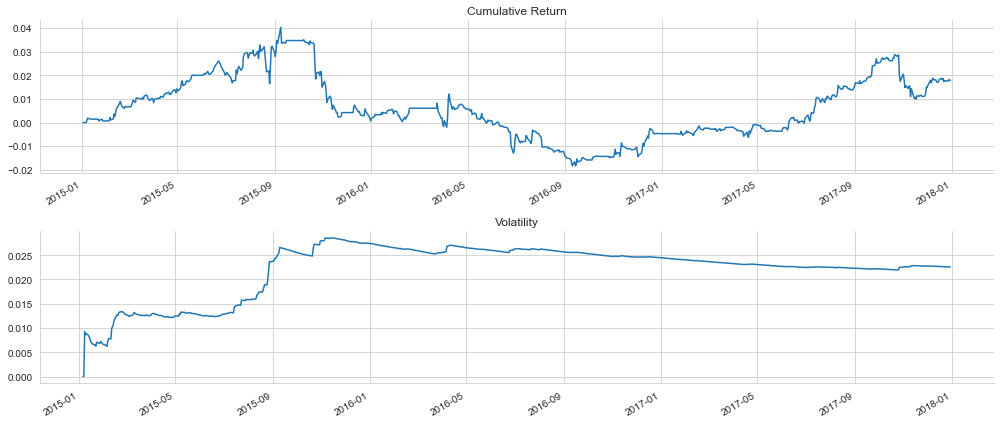

In [27]:
fig, axes = plt.subplots(nrows=2, figsize=(14,6))
result.algorithm_period_return.plot(ax=axes[0], title='Cumulative Return')
result.algo_volatility.plot(ax=axes[1], title='Volatility')
sns.despine()
fig.tight_layout();